In [61]:
from curves import bootstrap_contracts, max_smooth_interp, contract_period as cp, weighting, adjustments
from collections import namedtuple

PowerCurvePoint = namedtuple("PowerCurvePoint", "contract baseload_price peak_price")

curve_prices = [
    PowerCurvePoint(cp.jul(2022), 12.45, 29.55),
    PowerCurvePoint(cp.aug(2022), 11.23, 32.89),
    PowerCurvePoint(cp.q_3(2022), 12.41, 28.99),
    PowerCurvePoint(cp.q_4(2022), 16.07, 41.96),
    PowerCurvePoint(cp.q_1(2023), 17.84, 43.82),
    PowerCurvePoint(cp.summer(2023), 10.53, 28.65),
    PowerCurvePoint(cp.winter(2023), 15.98, 40.02)
]

# For simplicity same shaping ratios used for peak and offpeak, probably they should be different
shaping_ratios = [
    # month to quarter shaping
    (cp.dec(2022), cp.q_4(2022), 1.19),
    (cp.nov(2022), cp.q_4(2022), 0.96),
    (cp.jan(2023), cp.q_1(2023), 1.25),
    (cp.feb(2023), cp.q_1(2023), 1.08),
    
    # month to month shaping
    # Q2-23
    (cp.apr(2023), cp.may(2023), 1.05),
    (cp.may(2023), cp.jun(2023), 1.02),
    # Q3-23
    (cp.jul(2023), cp.aug(2023), 1.02),
    (cp.aug(2023), cp.sep(2023), 0.94),
    # Q4-23
    (cp.dec(2023), cp.nov(2023), 1.12),
    (cp.nov(2023), cp.oct(2023), 1.02),
    # Q1-24
    (cp.jan(2024), cp.feb(2024), 1.08),
    (cp.feb(2024), cp.mar(2024), 1.03),
        
    # quarter to quarter shaping
    (cp.q_2(2023), cp.q_3(2023), 0.98),
    (cp.q_4(2023), cp.q_1(2024), 0.96)
]



<AxesSubplot:title={'center':'Bootstrapped and Shaped Peak Curve'}>

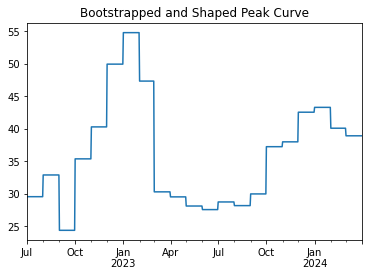

In [62]:
# Bootstrap and Shape Peak Prices to Monthly
raw_peak_curve_points = [(pcp.contract, pcp.peak_price) for pcp in curve_prices]

peak_weighting = weighting.num_weekdays()

monthly_peak_curve, bootstrapped_peak_contracts = \
    bootstrap_contracts(freq='M', contracts=raw_peak_curve_points, shaping_ratios=shaping_ratios, 
                       average_weight=peak_weighting)
piecewise_daily_peak_curve = monthly_peak_curve.resample('D').fillna('pad')

%matplotlib inline
piecewise_daily_peak_curve.plot(title='Bootstrapped and Shaped Peak Curve')


<AxesSubplot:title={'center':'Smoothed Versus Piecewise Daily Peak Curve'}>

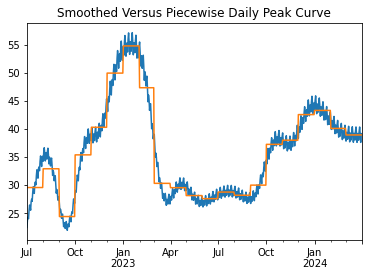

In [66]:
# Apply Spline to Calculate Daily Peak Price with Intra-week Shaping
peak_intra_week_shaping = adjustments.dayofweek(
    monday=0.97,
    tuesday=1.01,
    wednesday=1.03,
    thursday=1.00,
    friday=0.96,
    default=1.0
)

daily_peak_price = max_smooth_interp(monthly_peak_curve, freq='D', mult_season_adjust=peak_intra_week_shaping,
                                    average_weight=peak_weighting)
daily_peak_price.plot(title='Smoothed Versus Piecewise Daily Peak Curve')
piecewise_daily_peak_curve.plot()

In [ ]:
# Derive offpeak prices